In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

from encoder import *
from AttnDecoder import * 
from seq2seq import *

from build_dataset import *
from inference import *
from tqdm import tqdm

from beamsearch import *

/ext3/conda/zillow_MMKG/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to /home/az2575/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/az2575/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Load dataloaders 

In [2]:
# set whether or not model is pretrained and whether to use transformer for encoder or for whole seq2seq
model_pretrained = True
transformer_encoder = True
transformer_seq2seq = False

In [3]:
# load data 
main_data_path = "data/processed"

train_file_path = {
    'source': f"{main_data_path}/src-train.txt",
    'target': f"{main_data_path}/tgt-train.txt"
}

test_file_path = {
    'source': f"{main_data_path}/src-test.txt",
    'target': f"{main_data_path}/tgt-test.txt"
}

dev_file_path = {
    'source': f"{main_data_path}/src-dev.txt",
    'target': f"{main_data_path}/tgt-dev.txt"
}

# build vocab with train data only 
vocab = build_train_vocab(train_file_path)

# build datasets for all train, test, dev
datasets = {
    'train': QAPair(train_file_path, vocab),
    'test': QAPair(test_file_path, vocab),
    'dev': QAPair(dev_file_path, vocab),
}

# build dataloaders
batch_size = 64
dataloaders = {}
for split, dataset in datasets.items():
    dataloaders[split] = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        collate_fn=partial(pad_collate_fn, pad_token=dataset.pad_idx)
    )

# 2. Load parsed GloVe embeddings

In [4]:
embed_size = 300
pretrained_vectors = {
    'enc': torch.load(f'embeddings/encoder_emb_{embed_size}.pt').float(),
    'dec': torch.load(f'embeddings/decoder_emb_{embed_size}.pt').float()
}

# input_size = len(train_dataset.answer_vocab) 
output_size = len(vocab['target'])

# 3. Train loop

## 3.1 Define train and eval steps

In [5]:
def train_step(batch, model, optimizer, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    target_input = target[:, :-1]
    
    model.train()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target_input, inputs_len, target_len)
    
    optimizer.zero_grad()
    target_out = target[:, 1:]
    loss = criterion(dec_log_probs.transpose(1, 2), target_out)
    loss.backward()
    # clip gradients
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
    
    optimizer.step()

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat

def eval_step(batch, model, criterion, device):
    input = batch.source_vecs.to(device) 
    inputs_len = batch.source_lens.to(device)
    target = batch.target_vecs.to(device)
    target_len = batch.target_lens.to(device) 
    target_input = target[:, :-1]
    
    model.eval()

    dec_log_probs, dec_hidden, attn_scores_mat = model(input, target_input, inputs_len, target_len)

    target_out = target[:, 1:]
    loss = criterion(dec_log_probs.transpose(1, 2), target_out)

    # return the attention scores at the last time step
    return loss.item(), dec_log_probs, attn_scores_mat

## 3.2 Run train loop

In [6]:
# TRAIN LOOP 

# file name
file_name = 'trained_seq2seq_statedict'
if transformer_encoder:
    file_name += '_transformer_enc'
if transformer_seq2seq:
    file_name += '_transformer_seq2seq'
file_name += '.pt'

if not model_pretrained:
    # initial learning rate
    lr = 1.0
    # initialize the model, optimizer, and criterion
    seq2seq = Seq2Seq(pretrained_vectors, src_max_len=5000, hidden_size=600, output_size=output_size, transformer_encoder=transformer_encoder, transformer_seq2seq=transformer_seq2seq)
    optimizer = torch.optim.SGD(seq2seq.parameters(), lr=lr)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    seq2seq.to(device)

    plot_cache = {}
    plot_cache['train'] = []
    plot_cache['val'] = []

    # halve lr at epoch 8
    scheduler = StepLR(optimizer, step_size=8, gamma=0.5) 

    NUM_EPOCHS = 15
    for epoch in tqdm(range(NUM_EPOCHS)):    
        # train 
        train_losses = []
        for i, data in tqdm(enumerate(dataloaders['train']), leave=False):
            curr_loss, dec_log_probs, attn_scores_mat = train_step(data, seq2seq, optimizer, criterion, device)
            train_losses.append(curr_loss)

        avg_train_loss = np.mean(train_losses)
        print(f'Train loss after epoch {epoch+1} = {avg_train_loss}')

        # eval 
        val_losses = []
        with torch.no_grad():
            for i, data in tqdm(enumerate(dataloaders['dev']), leave=False):
                curr_loss, dec_log_probs, attn_scores_mat = eval_step(data, seq2seq, criterion, device)

                val_losses.append(curr_loss)

            avg_val_loss = np.mean(val_losses)
            print(f'Val loss after epoch {epoch+1} = {avg_val_loss}')

        plot_cache['train'].append(avg_train_loss)
        plot_cache['val'].append(avg_val_loss)

        scheduler.step()

    # save the model state
    torch.save({'state_dict': seq2seq.state_dict(), 'plot_cache': plot_cache}, file_name)
else:
    # reload the model
    seq2seq = Seq2Seq(pretrained_vectors, src_max_len=5000, hidden_size=600, output_size=output_size, transformer_encoder=transformer_encoder, transformer_seq2seq=transformer_seq2seq)
    criterion = nn.NLLLoss(ignore_index=datasets['train'].pad_idx)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    seq2seq.to(device)

    checkpoint = torch.load(file_name)
    seq2seq.load_state_dict(checkpoint['state_dict'])
    plot_cache = checkpoint['plot_cache']

In [7]:
# # run inference on the test set
# with torch.no_grad():
#     for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
#         # run evaluation on the test set
#         curr_loss, dec_log_probs, attn_scores_mat = eval_step(data, seq2seq, criterion, device)
#         test_losses.append(curr_loss)
        
#         # create a matrix of the best attention score SRC token class 
#         best_attn_labels = unk_postprocessing(data.source_vecs, attn_scores_mat)
#         all_best_attn_labels.append(best_attn_labels)

#         # run vanilla inference on the test set
#         preds_list, labels_list = vanilla_inference(dec_log_probs, data.target_vecs, vocab['target'])

#         # evaluate the predictions with the metrics
#         bleu_1, bleu_2, bleu_3, bleu_4, meteor, rouge_l = eval_metrics(preds_list, labels_list) # meteor, rouge_l
#         all_bleu_1.append(bleu_1)
#         all_bleu_2.append(bleu_2)
#         all_bleu_3.append(bleu_3)
#         all_bleu_4.append(bleu_4)
#         all_meteor.append(meteor)
#         all_rouge_l.append(rouge_l)

#         # replace all unk tokens with the SRC token with the highest attention
#         cleaned_preds_list = []
#         for sen_idx in range(len(preds_list)):
#             sentence = []
#             for tok_idx, token in enumerate(preds_list[sen_idx]):
#                 if token == '<unk>':
#                     src_id = int(best_attn_labels[sen_idx][tok_idx].item())
#                     src_token = vocab['source'].decode_idx2token([src_id])
#                     sentence.append(src_token[0])
#                 else:
#                     sentence.append(preds_list[sen_idx][tok_idx])
#             cleaned_preds_list.append(sentence)

#         all_preds_list.append(preds_list)
#         all_labels_list.append(labels_list)
#         all_cleaned_preds_list.append(cleaned_preds_list)
#         raw_labels_list.append(data.target_data)

#     avg_test_loss = np.mean(test_losses)
#     avg_bleu_1 = np.mean(all_bleu_1)
#     avg_bleu_2 = np.mean(all_bleu_2)
#     avg_bleu_3 = np.mean(all_bleu_3)
#     avg_bleu_4 = np.mean(all_bleu_4)
#     avg_meteor = np.mean(all_meteor)
#     avg_rouge_l = np.mean(all_rouge_l)

#     print(f'Average Test Loss = {avg_test_loss}')
#     print(f'Average BLEU_1 Score = {avg_bleu_1}')
#     print(f'Average BLEU_2 Score = {avg_bleu_2}')
#     print(f'Average BLEU_3 Score = {avg_bleu_3}')
#     print(f'Average BLEU_4 Score = {avg_bleu_4}')
#     print(f'Average METEOR Score = {avg_meteor}')
#     print(f'Average ROUGE_L Score = {avg_rouge_l}')

# run inference on the test set
test_losses = []
all_best_attn_labels = []
all_preds_list = []
all_labels_list = []
raw_labels_list = []
all_cleaned_preds_list = []
all_bleu_1 = []
all_bleu_2 = []
all_bleu_3 = []
all_bleu_4 = []
all_meteor = []
all_rouge_l = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
        # run beam search inference on the test set
        beam_search_batch(data, seq2seq, vocab['target'], device, beam_width=1, hidden_size=600, n_layers=2, transforer_encoder=transformer_encoder)

        # preds_list = []
        # labels_list = []
        # for j in range(len(data.source_vecs)):
        #     pred = generate_with_beam(seq2seq, data.source_data[j], vocab, beam_width=3)
        #     preds_list.append(pred)
        #     labels_list.append(data.target_data[i])

0it [00:00, ?it/s]

target question: ['what', 'year', 'did', 'beyoncé', 'first', 'model', 'for', 'tom', 'ford', '?']
argmax tensor([15], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([38], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([118], device='cuda:0')
argmax tensor([44], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([118], device='cuda:0')
argmax tensor([44], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([118], device='cuda:0')
argmax tensor([44], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([118], device='cuda:0')
argmax tensor([44], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], device='cuda:0')
argmax tensor([118], device='cuda:0')
argmax tensor([44], device='cuda:0')
argmax tensor([7], device='cuda:0')
argmax tensor([5], dev

KeyboardInterrupt: 

In [ ]:
# print out a few postprocesse predictions
for i in range(5):
    print('Target (Question) Label:', " ".join(raw_labels_list[0][i]))
    print('Target (Question) Raw Prediction:', " ".join(all_preds_list[0][i]))
    print('Target (Question) Postprocessed Prediction:', " ".join(all_cleaned_preds_list[0][i]))
    print('')

Target (Question) Label: in what year did queen anne die ?
Target (Question) Raw Prediction: in what year did queen anne die ?
Target (Question) Postprocessed Prediction: in what year did queen anne die ?

Target (Question) Label: when did the military operation end in rasht valley ?
Target (Question) Raw Prediction: when did the military operation end in <unk> valley ?
Target (Question) Postprocessed Prediction: when did the military operation end in . valley ?

Target (Question) Label: who orchestrated chopiniana ?
Target (Question) Raw Prediction: who <unk> <unk> ?
Target (Question) Postprocessed Prediction: who . 1909 ?

Target (Question) Label: how many quake lakes formed ?
Target (Question) Raw Prediction: how many ix lakes formed ?
Target (Question) Postprocessed Prediction: how many ix lakes formed ?

Target (Question) Label: to whom did chopin write a letter on 21 february 1842 about his agonizing pain ?
Target (Question) Raw Prediction: to whom did <unk> write a letter on 21 

In [ ]:
# PLOT TRAIN AND VAL LOSS
import matplotlib.pyplot as plt 
def plot_over_training(per_epoch_metrics, title_name, num_epochs):

    t = np.arange(1, num_epochs+1)

    fig, ax1 = plt.subplots(facecolor=(1, 1, 1))

    colors = ['tab:blue', 'tab:red']
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')

    for key, color in zip(per_epoch_metrics, colors):
        label = f'{key}_loss'
        ax1.plot(t, per_epoch_metrics[key], color=color, linewidth=1, label=label)

    ax1.tick_params(axis='y')
    ax1.legend(loc='upper right')

    # fig.tight_layout
    plt.title(title_name)

    # plot name
    plot_name = 'loss_plot'
    if transformer_encoder:
        plot_name += '_transformer_enc'
    if transformer_seq2seq:
        plot_name += '_transformer_seq2seq'
    plot_name += '.png'

    fig.savefig(plot_name)
    


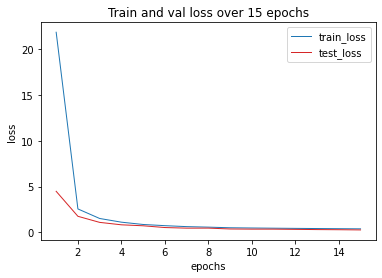

In [ ]:
plot_over_training(plot_cache, 'Train and val loss over 15 epochs', 15)

In [18]:
# def showAttention(input_sentence, output_words, attentions):
#     # Set up figure with colorbar
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attentions, cmap='bone', aspect='auto')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels([''] + input_sentence.split(' ') +
#                        [global_variables.EOS_TOKEN], rotation=90)
#     ax.set_yticklabels([''] + output_words.split(' ')+
#                        [global_variables.EOS_TOKEN])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

# def get_encoded_batch(sentence, lang_obj, use_cuda):
#     """ accepts only bsz = 1.
#         input: one sentence as a string
#         output: named tuple with vector and length"""
    
#     sentence = sentence + ' ' + global_variables.EOS_TOKEN
#     tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
#     device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
#     named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
#     return_tuple = named_returntuple( tensor.to(device), 
#                                      torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
#                                      None,
#                                      None,
#                                      False )

#     return return_tuple

# def get_translation(nmt_model, sentence, lang_obj, use_cuda, dec_type=''):
#     if dec_type == 'Basic RNN Decoder':
#         print('Source: ', sentence)
#     batch = get_encoded_batch(sentence, lang_obj, use_cuda)
#     prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True)
#     prediction = prediction[0]
#     print('Prediction for Model w/ {}: '.format(dec_type), prediction)

#     if attn_scores_list[0] is not None:
#         if attn_scores_list[0][0] is not None:
#             attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list]
#             attn_matrix = np.stack(attn_matrix)[:,:, 0]
#             showAttention(sentence, prediction, attn_matrix)

Target (Question) Label: what is the process called that can increase solar energy in areas further away from the earth 's equator ?
Target (Question) Raw Prediction: what is the process called that can increase solar energy in areas further away from the earth 's equator ?
Target (Question) Postprocessed Prediction: what is the process called that can increase solar energy in areas further away from the earth 's equator ?



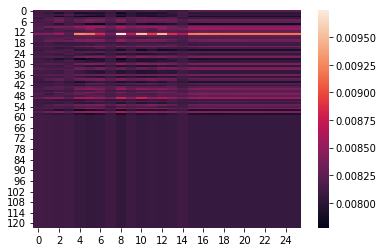

In [17]:
# from seaborn import heatmap
# # create the attention plot for one of the test records
# with torch.no_grad():
#     for i, data in tqdm(enumerate(dataloaders['test']), leave=False):
#         # run evaluation on the test set
#         curr_loss, dec_log_probs, attn_scores_mat = eval_step(data, seq2seq, criterion, device)
#         test_losses.append(curr_loss)
        
#         # create a matrix of the best attention score SRC token class 
#         best_attn_labels = unk_postprocessing(data.source_vecs, attn_scores_mat)
#         all_best_attn_labels.append(best_attn_labels)

#         # run vanilla inference on the test set
#         preds_list, labels_list = vanilla_inference(dec_log_probs, data.target_vecs, vocab['target'])

#         # replace all unk tokens with the SRC token with the highest attention
#         cleaned_preds_list = []
#         for sen_idx in range(len(preds_list)):
#             sentence = []
#             for tok_idx, token in enumerate(preds_list[sen_idx]):
#                 if token == '<unk>':
#                     src_id = int(best_attn_labels[sen_idx][tok_idx].item())
#                     src_token = vocab['source'].decode_idx2token([src_id])
#                     sentence.append(src_token[0])
#                 else:
#                     sentence.append(preds_list[sen_idx][tok_idx])
#             cleaned_preds_list.append(sentence)

#         attn_plot = attn_scores_mat[i]
#         # heatmap(attn_plot.cpu())

#         # print('Target (Question) Label:', " ".join(raw_labels_list[i][1]))
#         # print('Target (Question) Raw Prediction:', " ".join(all_preds_list[i][1]))
#         # print('Target (Question) Postprocessed Prediction:', " ".join(all_cleaned_preds_list[i][1]))
#         # print('')

#         for model_it in [(model_basic, 'Basic RNN Decoder'), (model_encoderattn, 'RNN Decoder w/ Encoder Attention')]:
#             get_translation(model_it[0], sentence, source_lang_obj, use_cuda, dec_type=model_it[1])
        
